In [55]:
import matplotlib.pyplot as plt
import numpy as np

from utils.angle_data import AngleData, SingleRun, get_data
# from utils import fresnel

from iminuit import Minuit, minuit

import glob

In [56]:
def r_12_p(theta, n1, n2):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n2 * np.cos(theta) - n1 * cos_theta2) / (n1 * cos_theta2 + n2 * np.cos(theta))
    )

def r_12_s(theta, n1, n2):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n1 * np.cos(theta) - n2 * cos_theta2) / (n1 * np.cos(theta) + n2 * cos_theta2)
    )

def r_23_p(theta, n1, n2, n3):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n3 * cos_theta2 - n2 * cos_theta3) / (n3 * cos_theta2 + n2 * cos_theta3)
    )

def r_23_s(theta, n1, n2, n3):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n2 * cos_theta2 - n3 * cos_theta3) / (n2 * cos_theta2 + n3 * cos_theta3)
    )
    
def phi(theta, ni, nt, d): 
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return 2 * np.pi * d * nt/ 532 * cos_transmitted
    
def construct_three_layer_r(r_al: callable, r_ls: callable, theta, n1, n2, n3, d):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    `n3`: complex refractive indices for material 3 (n = n + k*1j)
    `d` : inner layer width
    '''
    
    return (
        (r_al(theta, n1, n2) + r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))/
        (1 + r_al(theta, n1, n2) * r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))
    )


def Si_Rs(theta, n1, n2, n3, d, phase):
    rs_tot = construct_three_layer_r(r_12_s, r_23_s, theta - phase, n1, n2, n3, d)
    return np.abs( rs_tot * np.conj(rs_tot) )

def Si_Rp(theta, n1, n2, n3, d, phase):
    rp_tot = construct_three_layer_r(r_12_p, r_23_p, theta - phase, n1, n2, n3, d)
    return np.abs( rp_tot * np.conj(rp_tot) )


# Problemi con il fit

Abbiamo costruito la funzione di fit combinando le due funzioni, ovvero $$fcn = \sum_{i,\mathrm{R_s}}\left(\frac{(y_{i,\mathrm{R_s}} - f_1(x_i))^2}{\sigma_{i,\mathrm{R_s}}^2}\right) + \sum_{i,\mathrm{R_p}}\left(\frac{(y_{i,\mathrm{R_p}} - f_1(x_i))^2}{\sigma_{i,\mathrm{R_s}}^2}\right)$$

In questo modo però non otteniamo un risultato efficace.
Combinando così il chi$^2$ osserviamo che fnc=3800 circa, mentre eseguendo il fit singolarmente per le due funzioni avremo invece che questo risulta essere differente nei due casi. 

In [80]:
Si_s_adl = get_data(sorted(glob.glob('../data/dataSi_0/**.lvm')), 23)
Si_p_adl = get_data(sorted(glob.glob('../data/dataSi_1/**.lvm')), 23)

p_Si = SingleRun(Si_p_adl, Si_p_adl[-1])
s_Si = SingleRun(Si_s_adl, Si_s_adl[-1])

p_Si.reflectance_std += (0.01)

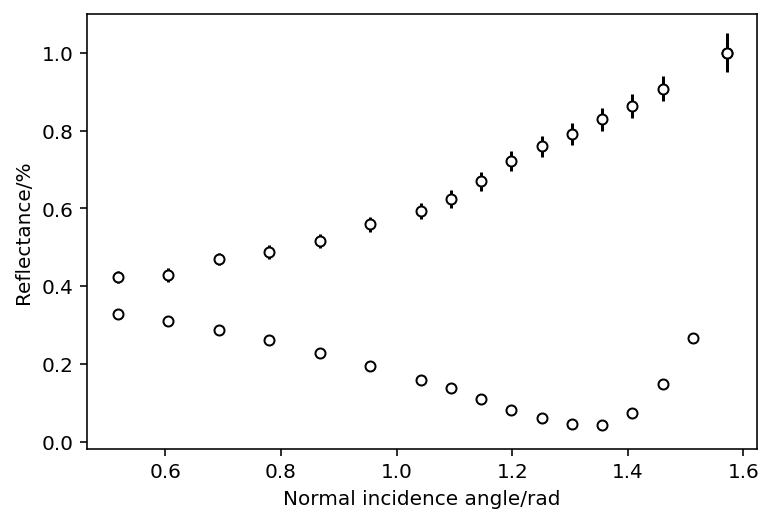

In [81]:
p_Si.plot()
s_Si.plot()

Come vorrei procedere:
 - Ottenere il fit combinato con la funzione riportata sopra, descrivendo bene quali sono i parametri che si sono fissati. Ottenere rispetto a tutti i parametri di fit curve di livello della minimizzazione. 
 - Ottenere il fit separato per $R_s$ e per $R_p$, considerare anche in questo caso tutti i parametri minimizzati e vedere come sono le curve di livello
     - comparare in questo caso anche il valore della funzione, eventualmente verificare che le normalizzzazioni non hanno senso
 - Ottenere il _fit dei poveri_ mettendo le funzioni in ordine e costruendo una funzione per punti (con delle theta di H), per verificare in questo modo che aspetto ha stacazzo di funzione. 
 - Verificare in tutti i casi compatibilità dei parametri stimati. 


In [82]:
from jacobi import propagate

def CLs_plot(m: Minuit, model: callable, cx, parameters, color):
    y, ycov = propagate(lambda p: model(cx, p), m.values, m.covariance)
    plt.plot(cx,y,color=color)
    plt.plot(cx, model(cx, parameters), 'k:')
    yerr_prop = np.diag(ycov) ** 0.5
    plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor=color, alpha=0.5)

In [83]:
parameters = [
    1.00027821,  # n_Air  
    0,
    1.4607,      # n_SiO2 
    0,
    4.1360,      # n_Si   
    0.010205,    # k_Si   
    2,
    0,
]

In [84]:
def p_plot(m_Rp: Minuit, m_Rs: Minuit):
    
    names = [
        '$n_\mathrm{Air}$',
        '$\kappa_\mathrm{Air}$',
        '$n_\mathrm{SiO_2}$',
        '$\kappa_\mathrm{SiO_2}$',
        '$n_\mathrm{Si}$',
        '$\kappa_\mathrm{Si}$',
        '$d$',
        '$\phi$'
    ]
    
    i = 0
    
    fig, axs = plt.subplots(8, 1,figsize=(5, 10))
    fig.tight_layout()
    
    for val_Rp, std_Rp, val_Rs, std_Rs in zip(m_Rp.values, m_Rp.errors, m_Rs.values, m_Rs.errors):
        axs[i].errorbar(val_Rp, 0.05, xerr=std_Rp, color='r', ecolor='r', fmt='o', mfc='w', label='$\chi^2_\mathrm{R_p}$ model')
        axs[i].errorbar(val_Rs, -0.05, xerr=std_Rs, color='b', ecolor='b', fmt='o', mfc='w', label='$\chi^2_\mathrm{R_s}$ model')
        axs[i].set_yticks([0], [names[i]])
        axs[i].set_ylim(-0.2,0.2)
        axs[i].set_title(f'NIST value {parameters[i]}')
        i += 1
    plt.legend(frameon=False,loc=(1.2, 0))

        

## Fit separati

Eseguo fit indipendenti su ciascun set di dati, minimizzando separatamente $\chi^2_{R_s}$ e $\chi^2_{R_p}$, e poi considero la propagazione sia sulle curve rispettive che sull'opposto, nei plot successivi

### Fit $\chi^2_{R_p}$

In [85]:
from iminuit.cost import LeastSquares

model_Rp = lambda x, p: Si_Rp(x, p[0]+1j*p[1], p[2]+1j*p[3], p[4]+1j*p[5],p[6],p[7])
fcn = LeastSquares(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std*(1.5), model_Rp)
m_Rp = Minuit(fcn, parameters)

# m_Rp.fixed[0] = True
# m_Rp.fixed[1] = True
# m_Rp.fixed[2] = True
# m_Rp.fixed[3] = True
# m_Rp.fixed[4] = True
# m_Rp.fixed[5] = True

# m_Rp.fixed[7] = True

In [86]:
m_Rp.migrad()
m_Rp.hesse()
m_Rp.migrad()
m_Rp.migrad()
m_Rp.hesse()
m_Rp.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.39 (chi2/ndof = 3.0)    │              Nfcn = 780              │
│ EDM = 0.000158 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.05    │   0.14    │            │            │         │         │       │
│ 1 │ x1   │   -0.1    │    0.4    │            │            │         │         │       │
│ 2 │ x2   │    0.4    │    0.5    │            │            │         │         │       │
│ 3 │ x3   │   -0.71   │   0.30    │            │            │         │         │       │
│ 4 │ x4   │    4.0    │    0.5    │            │            │         │         │       │
│ 5 │ x5   │   -0.1    │    1.1    │            │            │         │         │       │
│ 6 │ x6   │    2.4    │    1.8    │            │            │         │         │       │
│ 7 │ x7   │  0.7e-3   │  0.9e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │    0.0184  -0.00563    0.0128   -0.0096    0.0638   0.00921   -0.0418 -2.08e-06 │
│ x1 │  -0.00563     0.178   -0.0199    0.0405    0.0325     0.185     0.202 -3.51e-07 │
│ x2 │    0.0128   -0.0199     0.224  -0.00891   0.00465     0.358     0.243 -8.95e-07 │
│ x3 │   -0.0096    0.0405  -0.00891      0.09   -0.0369     0.204    -0.357 -8.13e-06 │
│ x4 │    0.0638    0.0325   0.00465   -0.0369     0.261    0.0108    -0.118 -3.27e-08 │
│ x5 │   0.00921     0.185     0.358     0.204    0.0108      1.24    -0.309   2.4e-05 │
│ x6 │   -0.0418     0.202     0.243    -0.357    -0.118    -0.309      3.27 -1.67e-05 │
│ x7 │ -2.08e-06 -3.51e-07 -8.95e-07 -8.13e-06 -3.27e-08   2.4e-05 -1.67e-05  7.67e-07 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

### Fit $\chi^2_{R_s}$

In [87]:
model_Rs = lambda x, p: Si_Rs(x, p[0]+1j*p[1], p[2]+1j*p[3], p[4]+1j*p[5],p[6],p[7])
fcn = LeastSquares(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std, model_Rs)
m_Rs = Minuit(fcn, parameters)

# m_Rs.fixed[0] = True
# m_Rs.fixed[1] = True
# m_Rs.fixed[2] = True
# m_Rs.fixed[3] = True
# m_Rs.fixed[4] = True
# m_Rs.fixed[5] = True

# m_Rs.fixed[7] = True

In [88]:
m_Rs.migrad()
m_Rs.hesse()
m_Rs.migrad()
m_Rs.migrad()
m_Rs.hesse()
m_Rs.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.436 (chi2/ndof = 0.4)    │              Nfcn = 631              │
│ EDM = 9.53e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ x1   │   0.01    │   0.22    │            │            │         │         │       │
│ 2 │ x2   │     2     │     4     │            │            │         │         │       │
│ 3 │ x3   │   -0.1    │    0.9    │            │            │         │         │       │
│ 4 │ x4   │   4.11    │   0.23    │            │            │         │         │       │
│ 5 │ x5   │     0     │    12     │            │            │         │         │       │
│ 6 │ x6   │     7     │    13     │            │            │         │         │       │
│ 7 │ x7   │  -0.024   │   0.015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00318  0.000624     0.034   0.00465  0.000825    -0.229  -0.00142 -2.85e-05 │
│ x1 │  0.000624     0.047     0.349   0.00074  -0.00318     -1.56     0.163   6.2e-05 │
│ x2 │     0.034     0.349      17.7    -0.113    -0.153     -37.7       6.1   0.00356 │
│ x3 │   0.00465   0.00074    -0.113     0.753    -0.018      2.38     0.913  0.000367 │
│ x4 │  0.000825  -0.00318    -0.153    -0.018    0.0522     0.978   -0.0137  0.000105 │
│ x5 │    -0.229     -1.56     -37.7      2.38     0.978       142     -57.2   -0.0194 │
│ x6 │  -0.00142     0.163       6.1     0.913   -0.0137     -57.2       160   0.00171 │
│ x7 │ -2.85e-05   6.2e-05   0.00356  0.000367  0.000105   -0.0194   0.00171  0.000214 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

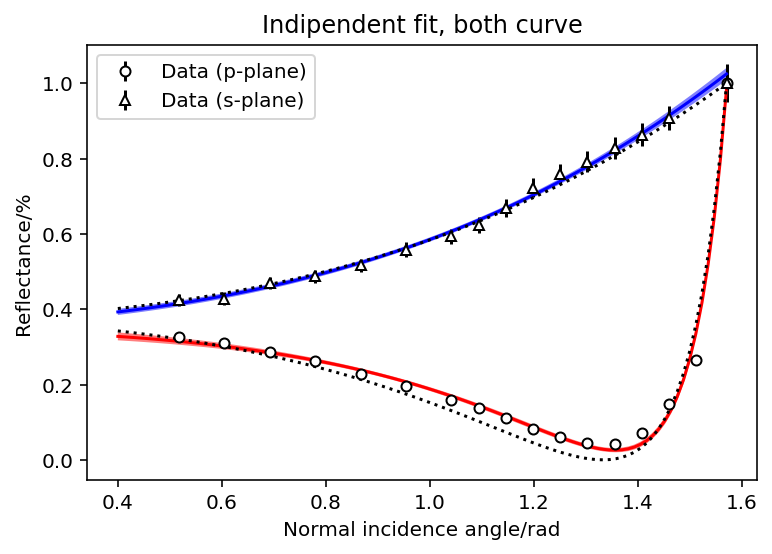

In [89]:
p_Si.plot(marker='o')
s_Si.plot(marker='^')

angles = np.linspace(0.4, np.pi/2, 100)

CLs_plot(m_Rp, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rs, model_Rs, angles, parameters, color='b')
plt.title('Indipendent fit, both curve')
plt.legend()

Text(0.5, 1.0, 'Fit on $R_p$, propagated on both')

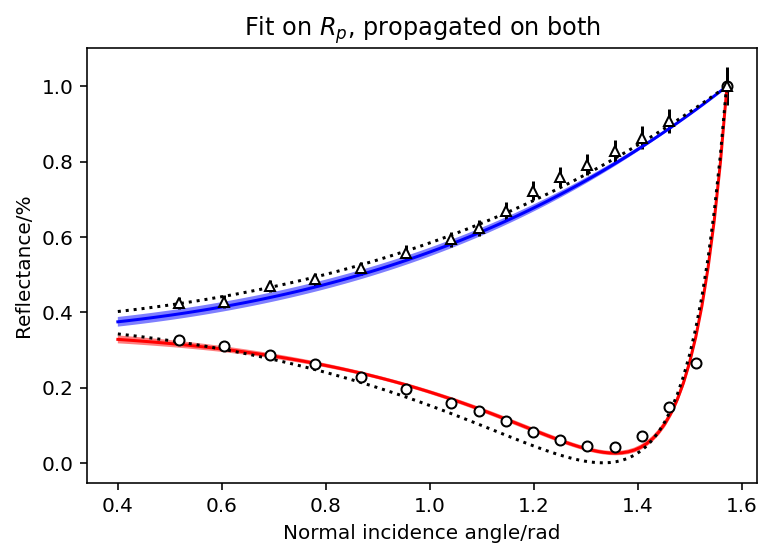

In [90]:
p_Si.plot(marker='o')
s_Si.plot(marker='^')

CLs_plot(m_Rp, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rp, model_Rs, angles, parameters, color='b')
plt.title('Fit on $R_p$, propagated on both')

(-0.1, 1.1)

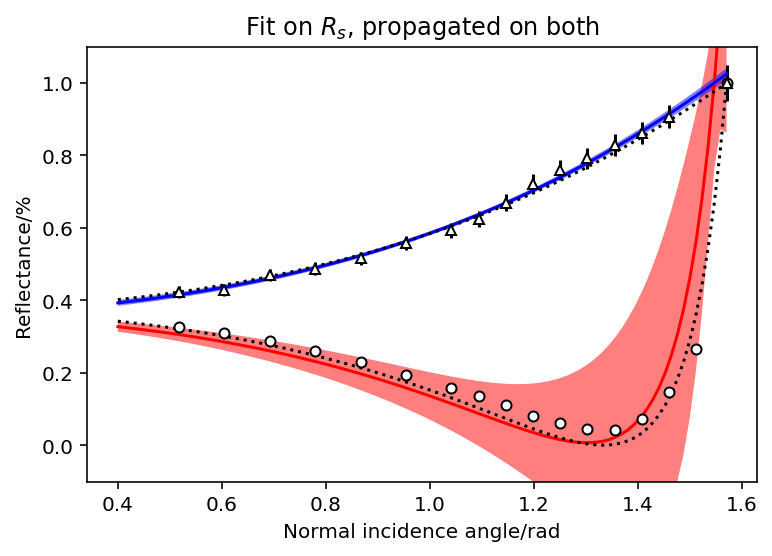

In [91]:
p_Si.plot(marker='o')
s_Si.plot(marker='^')

CLs_plot(m_Rs, model_Rp, angles, parameters, color='r')
CLs_plot(m_Rs, model_Rs, angles, parameters, color='b')
plt.title('Fit on $R_s$, propagated on both')
plt.ylim(-0.1, 1.1)

Osserviamo che sull'ultimo valore abbiamo un leggero shift del grafico rispetto alla previsione. 

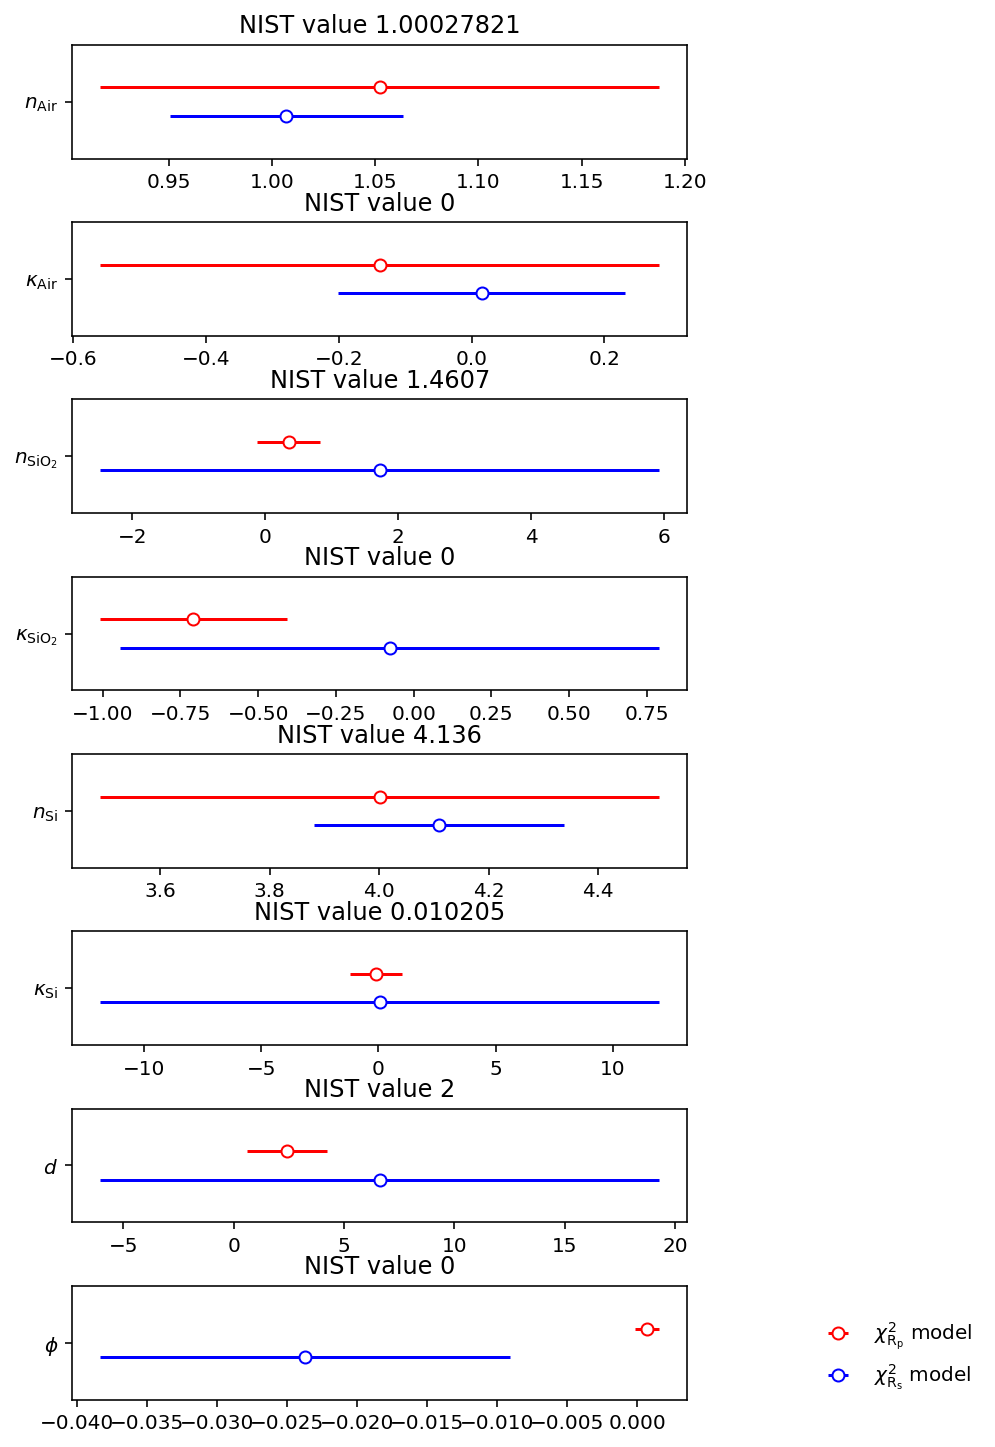

In [92]:
p_plot(m_Rp, m_Rs)

(array([-18.70732511, -18.19569806, -17.68407101, -17.17244396,
        -16.6608169 , -16.14918985, -15.6375628 , -15.12593575,
        -14.6143087 , -14.10268165, -13.5910546 , -13.07942755,
        -12.5678005 , -12.05617345, -11.5445464 , -11.03291935,
        -10.5212923 , -10.00966525,  -9.4980382 ,  -8.98641114,
         -8.47478409,  -7.96315704,  -7.45152999,  -6.93990294,
         -6.42827589,  -5.91664884,  -5.40502179,  -4.89339474,
         -4.38176769,  -3.87014064,  -3.35851359,  -2.84688654,
         -2.33525949,  -1.82363244,  -1.31200538,  -0.80037833,
         -0.28875128,   0.22287577,   0.73450282,   1.24612987,
          1.75775692,   2.26938397,   2.78101102,   3.29263807,
          3.80426512,   4.31589217,   4.82751922,   5.33914627,
          5.85077332,   6.36240038,   6.87402743,   7.38565448,
          7.89728153,   8.40890858,   8.92053563,   9.43216268,
          9.94378973,  10.45541678,  10.96704383,  11.47867088,
         11.99029793,  12.50192498,  13.

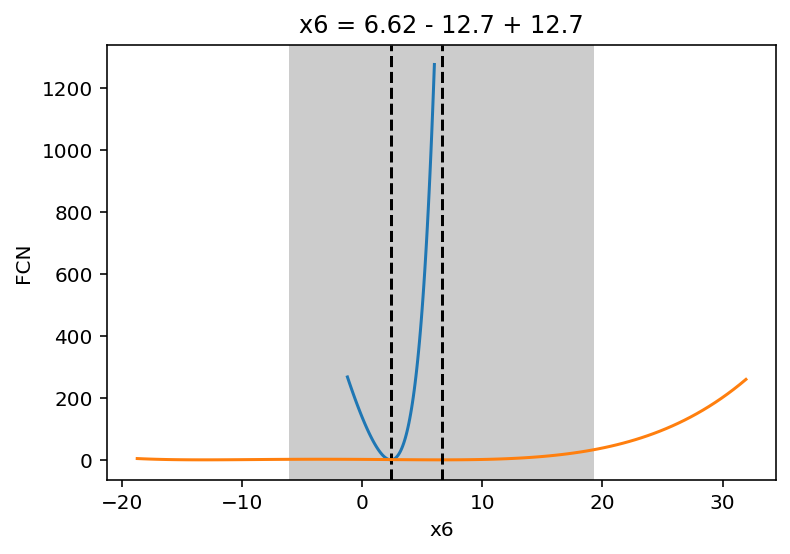

In [93]:
m_Rp.draw_profile('x6')
m_Rs.draw_profile('x6')


## Fit combinato

Definiamo una distribuzione combinata (non normalizzata) del chi$^2$ come $\chi^2 = \chi^2_{R_p} + \chi^2_{R_s}$, e minimizziamo.

In [94]:
class CommLS_RPRS:
    
    errordef = Minuit.LEAST_SQUARES
    
    def __init__(self, xRRp, xRRs, RRp, err_RRp, RRs, err_RRs, Rp: callable, Rs: callable):
        self.xRRp = np.asarray(xRRp)
        self.xRRs = np.asarray(xRRs)
        
        self.RRp = np.asarray(RRp)
        self.err_RRp = np.asarray(err_RRp)
        self.RRs = np.asarray(RRs)
        self.err_RRs = np.asarray(err_RRs)
        self.Rp = Rp
        self.Rs = Rs
        
    def __call__(self, *par):
        chi2Rp = np.sum(((self.RRp - self.Rp(self.xRRp, *par))/self.err_RRp)**2)
        chi2Rs = np.sum(((self.RRs - self.Rs(self.xRRs, *par))/self.err_RRs)**2)
        
        return chi2Rp + chi2Rs

In [95]:
fcn = CommLS_RPRS(p_Si.angles, s_Si.angles, p_Si.reflectance, p_Si.reflectance_std, s_Si.reflectance, s_Si.reflectance_std, model_Rp, model_Rs)
mCommRR = Minuit(fcn, parameters)

# mCommRR.fixed[0] = True
# mCommRR.fixed[1] = True
# mCommRR.fixed[2] = True
# mCommRR.fixed[3] = True
# mCommRR.fixed[4] = True
# mCommRR.fixed[5] = True
# mCommRR.fixed[7] = True

In [96]:
mCommRR.migrad()
mCommRR.hesse()
mCommRR.migrad()
mCommRR.migrad()
mCommRR.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 63.72                      │             Nfcn = 2195              │
│ EDM = 4.8e-07 (Goal: 0.0002)     │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.32    │   0.13    │            │            │         │         │       │
│ 1 │ x1   │   -2.75   │   0.16    │            │            │         │         │       │
│ 2 │ x2   │   0.004   │   0.005   │            │            │         │         │       │
│ 3 │ x3   │  -0.126   │   0.007   │            │            │         │         │       │
│ 4 │ x4   │   5.98    │   0.34    │            │            │         │         │       │
│ 5 │ x5   │   0.71    │   0.18    │            │            │         │         │       │
│ 6 │ x6   │  0.0142   │  0.0016   │            │            │         │         │       │
│ 7 │ x7   │  0.7e-3   │  0.6e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │     0.018    -0.012  0.000216 -0.000291   0.00229    0.0182 -6.02e-05 -2.63e-06 │
│ x1 │    -0.012    0.0255   0.00047  0.000494  -0.00828  0.000327  6.57e-05   1.7e-06 │
│ x2 │  0.000216   0.00047  2.64e-05  3.19e-06   0.00016  0.000639 -3.06e-07  4.43e-08 │
│ x3 │ -0.000291  0.000494  3.19e-06  5.21e-05  -0.00107  6.64e-05 -4.58e-06 -6.06e-09 │
│ x4 │   0.00229  -0.00828   0.00016  -0.00107     0.114    -0.019 -0.000236  2.05e-06 │
│ x5 │    0.0182  0.000327  0.000639  6.64e-05    -0.019    0.0315 -1.01e-05 -1.03e-06 │
│ x6 │ -6.02e-05  6.57e-05 -3.06e-07 -4.58e-06 -0.000236 -1.01e-05  2.43e-06  -8.9e-09 │
│ x7 │ -2.63e-06   1.7e-06  4.43e-08 -6.06e-09  2.05e-06 -1.03e-06  -8.9e-09  3.34e-07 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

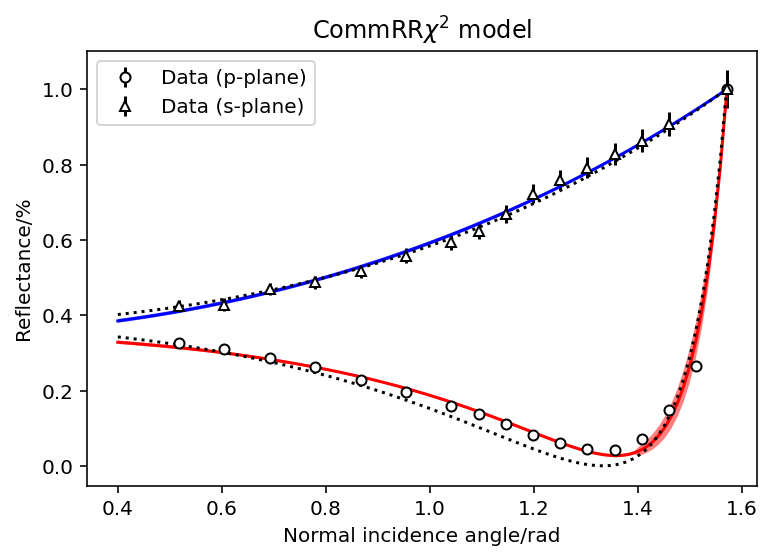

In [97]:
p_Si.plot(marker='o')
s_Si.plot(marker='^')

CLs_plot(mCommRR, model_Rp, angles, parameters, color='r')
CLs_plot(mCommRR, model_Rs, angles, parameters, color='b')
plt.title('CommRR$\chi^2$ model')
plt.legend()

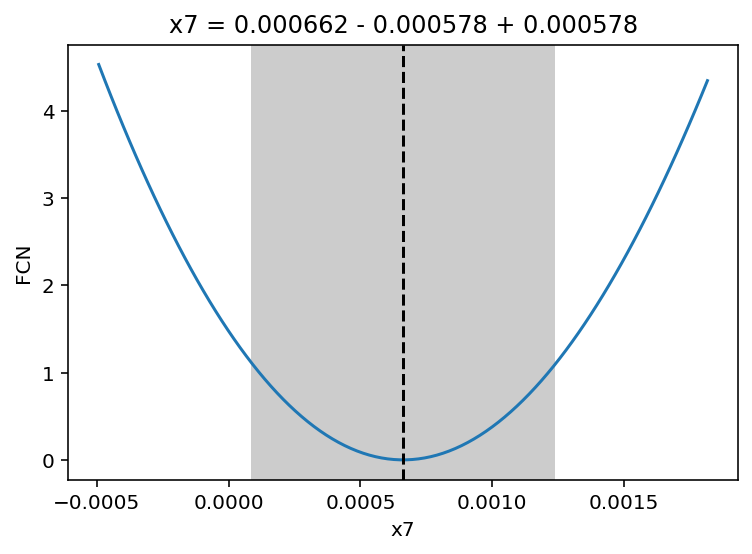

In [98]:
_ = mCommRR.draw_profile('x7')

In [99]:
fcn = LeastSquares(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std, model_Rs) + LeastSquares(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std, model_Rp)
mCommRRχ2_Minuit = Minuit(fcn, parameters)

In [100]:
mCommRRχ2_Minuit.fixed[0] = True
mCommRRχ2_Minuit.fixed[1] = True
# mCommRRχ2_Minuit.fixed[2] = True
mCommRRχ2_Minuit.fixed[3] = True
# mCommRRχ2_Minuit.fixed[4] = True
# mCommRRχ2_Minuit.fixed[5] = True
# mCommRRχ2_Minuit.fixed[7] = True

In [101]:
mCommRRχ2_Minuit.migrad()
mCommRRχ2_Minuit.hesse()
mCommRRχ2_Minuit.migrad()
mCommRRχ2_Minuit.migrad()
mCommRRχ2_Minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 67.05 (chi2/ndof = 2.4)    │             Nfcn = 1253              │
│ EDM = 1.75e-09 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   1.79    │   0.10    │            │            │         │         │       │
│ 3 │ x3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ x4   │   1.04    │   0.12    │            │            │         │         │       │
│ 5 │ x5   │   -1.19   │   0.22    │            │            │         │         │       │
│ 6 │ x6   │    69     │     5     │            │            │         │         │       │
│ 7 │ x7   │  0.7e-3   │  0.6e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0         0         0 │
│ x2 │         0         0   0.00907         0  -0.00614    0.0171      0.19  8.39e-06 │
│ x3 │         0         0         0         0         0         0         0         0 │
│ x4 │         0         0  -0.00614         0    0.0138   -0.0239    -0.574  7.89e-06 │
│ x5 │         0         0    0.0171         0   -0.0239    0.0482     0.931 -1.63e-06 │
│ x6 │         0         0      0.19         0    -0.574     0.931        25   -0.0004 │
│ x7 │         0         0  8.39e-06         0  7.89e-06 -1.63e-06   -0.0004  3.44e-07 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

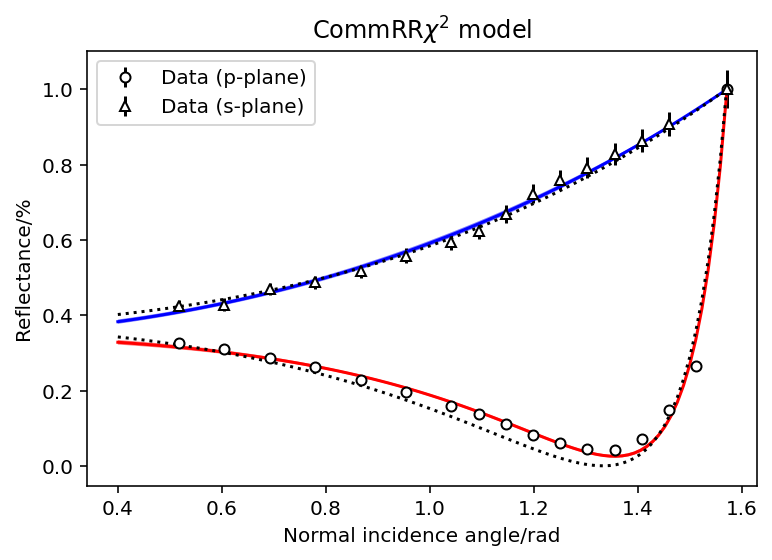

In [104]:
p_Si.plot(marker='o')
s_Si.plot(marker='^')

CLs_plot(mCommRRχ2_Minuit, model_Rp, angles, parameters, color='r')
CLs_plot(mCommRRχ2_Minuit, model_Rs, angles, parameters, color='b')
plt.title('CommRR$\chi^2$ model')
plt.legend()

In [110]:
(s_Si.reflectance_std/s_Si.reflectance), (p_Si.reflectance_std/p_Si.reflectance)

(array([0.03836306, 0.03972892, 0.03522519, 0.03532012, 0.03554144,
        0.03543517, 0.03549051, 0.03553616, 0.03519155, 0.03521333,
        0.0351895 , 0.03520371, 0.03519142, 0.0351931 , 0.03519087,
        0.04976475]),
 array([0.03111659, 0.03305757, 0.03521168, 0.03961558, 0.04401489,
        0.05151351, 0.06321431, 0.0745841 , 0.09096262, 0.13234712,
        0.16495134, 0.22924675, 0.23693231, 0.14111118, 0.07163124,
        0.04738054, 0.01040996]))